In [1]:
import core
import numpy as np
import visualization as vis
import matplotlib.pyplot as plt
flight=core.create_scene("config123_0619.json")

# Synchronization of Detection Data to a Unified Time Basis

In [2]:
#Initialize the alpha for each camera, using the first camera as the standard, 
# calculating the formula alpha for a camera = the first camera's fps/ its fps
flight.init_alpha()

#Initializes the beta of each camera, converting the cf set at the beginning to their corresponding time, 
# using the first camera's time as the standard, the first camera's time is its frame count.
flight.time_shift()
#According to alpha and beta, the fps corresponding to detection is converted into global time, 
# where detection needs to be calibrated in coordinate position.
flight.detection_to_global()

# Generation of Initial 3D Trajectory

In [3]:
# Initialize the first 3D trajectory
flight.init_traj()

# Trajectory Interpolation

In [13]:
# Convert discrete trajectory to spline representation
flight.traj_to_spline()

# Integration of Multi-Camera Data

In [14]:
for cam_id in range(2,len(flight.sequence)):
    flight.get_camera_pose(flight.sequence[cam_id])
    # Triangulate new points and update the 3D spline
    flight.triangulate(flight.sequence[cam_id], flight.sequence[:cam_id])

# Trajectory Continuation

In [15]:
flight.spline_to_traj()

In [17]:
flight.align_gt(flight.gt['frequency'], flight.gt['filepath'])

# Calculation of Similarity Transformation Matrix between Camera 0 and World Coordinates

In [22]:
M=flight.getSimilarityTransformationMatrix0w()

[[-0.          0.33123602 -0.32471372]
 [-0.          0.27488094  0.30660533]
 [-0.          0.90262017  1.01886651]]
[[139.64 156.03 210.67]
 [157.54 101.51 138.01]
 [ 98.15 188.9  180.16]]
RMSE = 3.5223


# Transformation of Trajectory to World Coordinates

In [23]:
reconstruction_result=np.dot(M,core.homogeneous(flight.traj[1:]))[:3]

# Reconstructed trajectory and complete trajectory

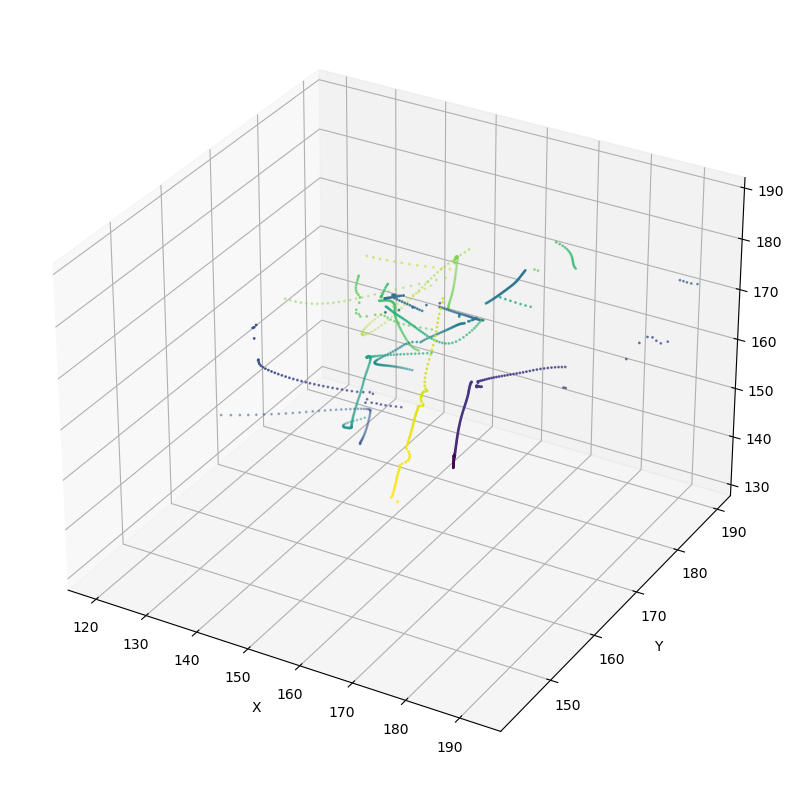

In [25]:
vis.show_trajectory_3D(reconstruction_result, line=False,size=1)

# Calculate the conversion of UAV and camera time and interpolate the UAV flight path according to the camera frame rate

In [30]:
#Correspond the gt time to the camera time
t_gt = flight.pre_process_and_find_best_match(M)
#Get the time the camera captures the presence of the object
_, idx = core.sampling(t_gt, flight.spline['int'])
gt_part = flight.gt_ori[:,idx]
t_part = t_gt[idx]
# Find the trajectory for the time period with the actual trajectory
flight.spline_to_traj(t=t_part)

# Draw scatter plots

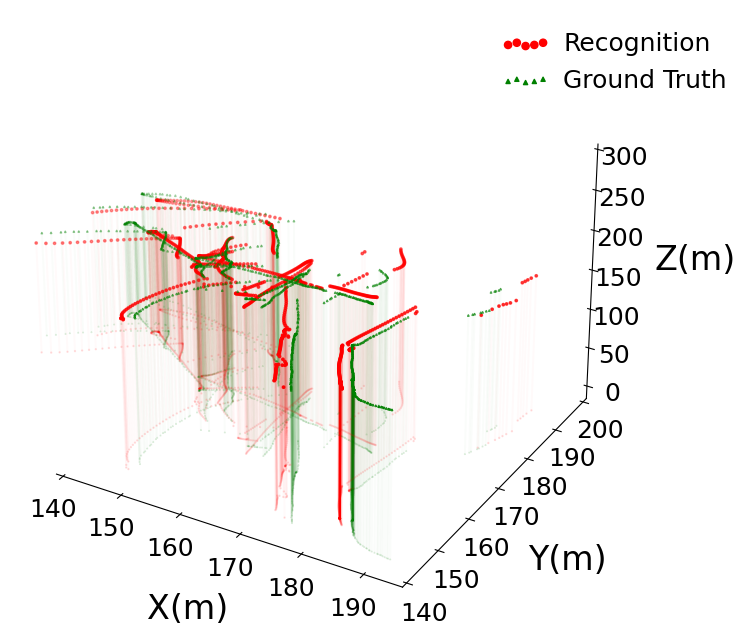

In [31]:
reconstruction_result=np.dot(M,core.homogeneous(flight.traj[1:]))[:3]
vis.plot_reconstruction_vs_ground_truth(reconstruction_result=reconstruction_result, ground_truth=gt_part,scatter=True, output_file='Reconstructed-trajectory-result-scatter.pdf')

# Draw a line graph

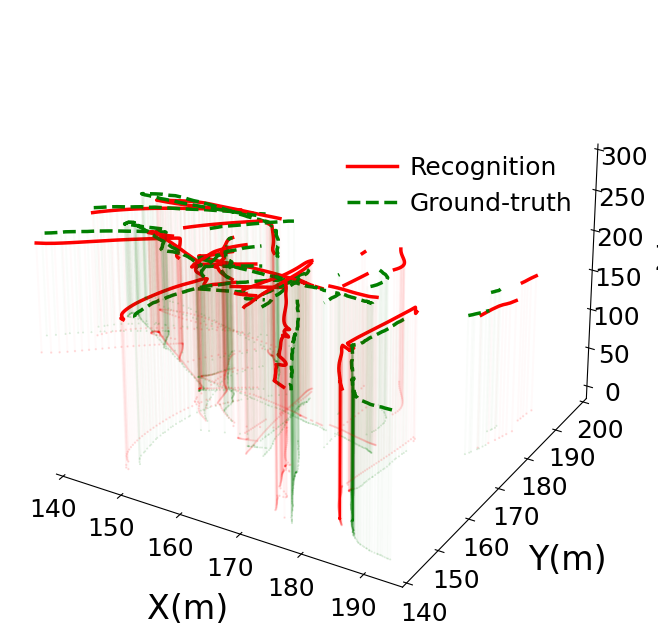

In [32]:
time_stamp = flight.traj[0]
vis.plot_reconstruction_vs_ground_truth(reconstruction_result=reconstruction_result, ground_truth=gt_part,scatter=False,time_stamp=time_stamp,linewidth=2.5,bbox_to_anchor=(0.95,0.8), output_file='Reconstructed-trajectory-result-line.pdf')

# xyz result visualization

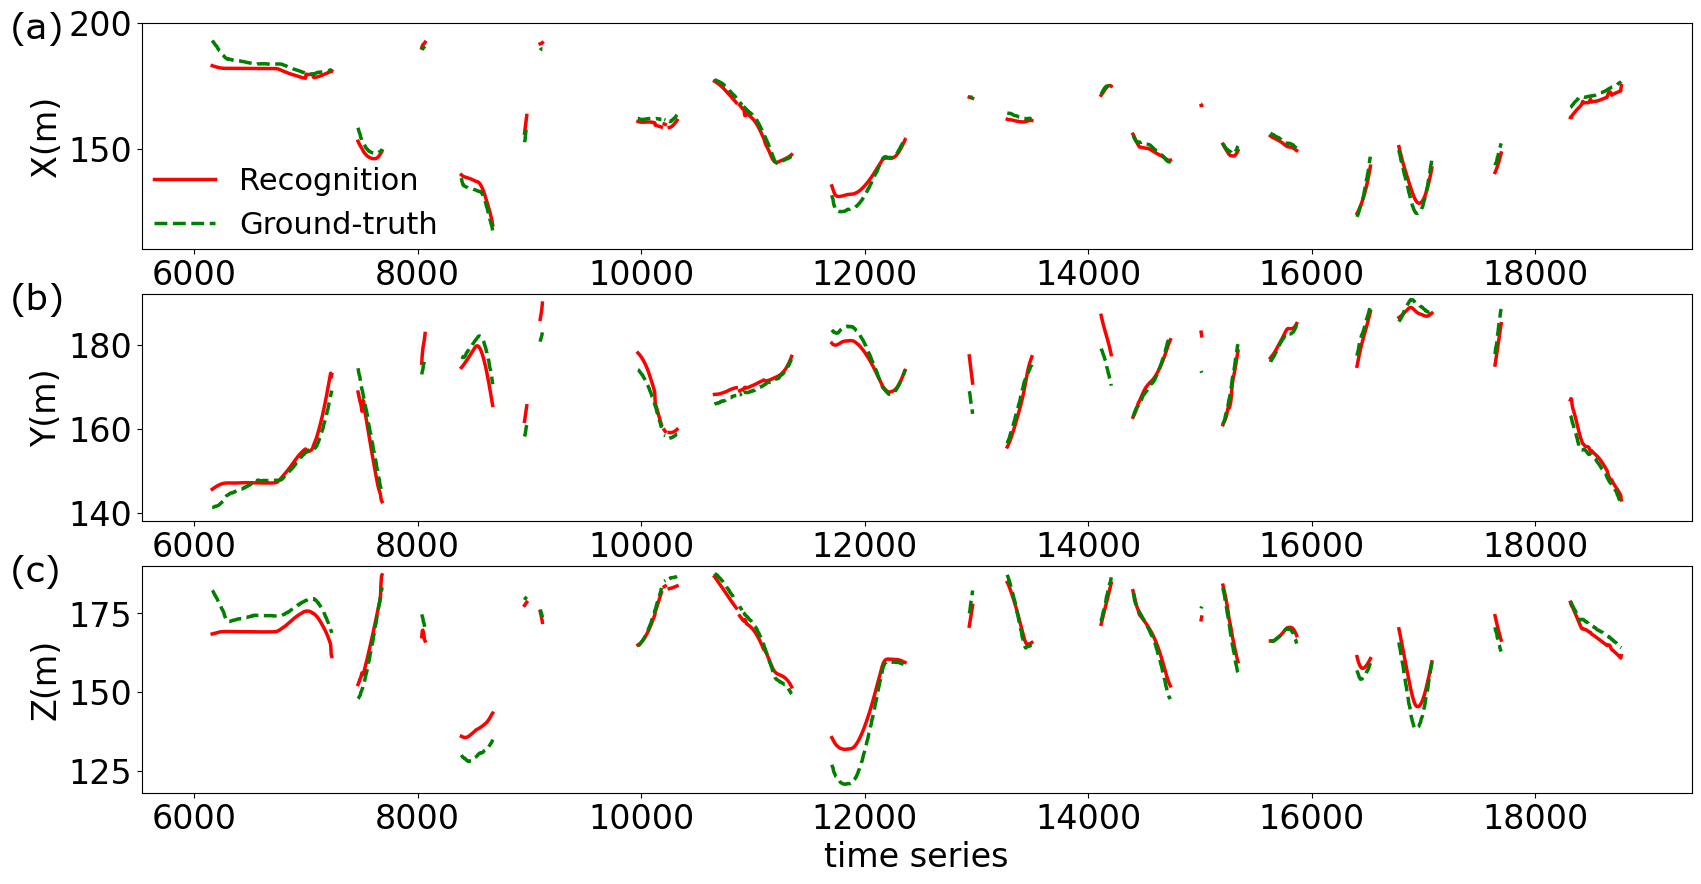

In [33]:
time_stamp = flight.traj[0]
vis.plot_trajectory_comparison(reconstruction_result=reconstruction_result, ground_truth=gt_part,time_stamp=time_stamp, output_file='Reconstructed-trajectory-resultXYZ.pdf', x_offset=-0.085, y_offset=1.05, font_weight='normal', font_size=26,font_family="Verdana")

# metrics of 3D UAV coordinate recognition

In [34]:
reconstruction_result = np.dot(M,core.homogeneous(flight.traj[1:]))[:3]
err_arr=gt_part.T-reconstruction_result.T

euclidean_distances = np.linalg.norm(err_arr, axis=1)
rmse = np.sqrt(np.mean(euclidean_distances**2))
mae = np.mean(euclidean_distances)
max_err = np.max(euclidean_distances)

mean_groundtruth = np.mean(gt_part, axis=1)

center_distances = np.linalg.norm(gt_part.T - mean_groundtruth, axis=1)

ss_total = np.sum((center_distances) ** 2)
ss_residual = np.sum(euclidean_distances ** 2)
# R²
r_squared = 1 - (ss_residual / ss_total)


print(f"RMSE: {rmse:.5f}")
print(f"MAE: {mae:.5f}")
print(f"Maximum Error: {max_err:.5f}")
print(f"R-squared: {r_squared:.5f}")

RMSE: 5.82373
MAE: 4.94927
Maximum Error: 17.61648
R-squared: 0.95888


## X

In [35]:
x_result=reconstruction_result[0]
x_groundtruth=gt_part[0]
rmse = np.sqrt(np.mean((x_result-x_groundtruth)**2))
mae = np.mean(np.abs(x_result-x_groundtruth))
max_err = np.max(np.abs(x_result-x_groundtruth))

mean_groundtruth_x = np.mean(x_groundtruth)

center_distances = np.linalg.norm(x_groundtruth - mean_groundtruth_x)

ss_total = np.sum((center_distances) ** 2)
ss_residual = np.sum((x_result-x_groundtruth) ** 2)
# R²
r_squared = 1 - (ss_residual / ss_total)
print(f"RMSE: {rmse:.5f}")
print(f"MAE: {mae:.5f}")
print(f"Maximum Error: {max_err:.5f}")
print(f"R-squared: {r_squared:.5f}")

RMSE: 2.69901
MAE: 2.19131
Maximum Error: 10.00713
R-squared: 0.97981


## Y

In [36]:
y_result=reconstruction_result[1]
y_groundtruth=gt_part[1]
rmse = np.sqrt(np.mean((y_result-y_groundtruth)**2))
mae = np.mean(np.abs(y_result-y_groundtruth))
max_err = np.max(np.abs(y_result-y_groundtruth))


mean_groundtruth_y = np.mean(y_groundtruth)

center_distances = np.linalg.norm(y_groundtruth - mean_groundtruth_y)

ss_total = np.sum((center_distances) ** 2)
ss_residual = np.sum((y_result-y_groundtruth) ** 2)
# R²
r_squared = 1 - (ss_residual / ss_total)

print(f"RMSE: {rmse:.5f}")
print(f"MAE: {mae:.5f}")
print(f"Maximum Error: {max_err:.5f}")
print(f"R-squared: {r_squared:.5f}")

RMSE: 2.45532
MAE: 1.85441
Maximum Error: 9.26024
R-squared: 0.96640


## Z

In [37]:
z_result=reconstruction_result[2]
z_groundtruth=gt_part[2]
rmse = np.sqrt(np.mean((z_result-z_groundtruth)**2))
mae = np.mean(np.abs(z_result-z_groundtruth))
max_err = np.max(np.abs(z_result-z_groundtruth))


mean_groundtruth_z = np.mean(z_groundtruth)

center_distances = np.linalg.norm(z_groundtruth - mean_groundtruth_z)

ss_total = np.sum((center_distances) ** 2)
ss_residual = np.sum((z_result-z_groundtruth) ** 2)
# R²
r_squared = 1 - (ss_residual / ss_total)

print(f"RMSE: {rmse:.5f}")
print(f"MAE: {mae:.5f}")
print(f"Maximum Error: {max_err:.5f}")
print(f"R-squared: {r_squared:.5f}")

RMSE: 4.53901
MAE: 3.54555
Maximum Error: 13.82706
R-squared: 0.92761
